In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import os

sys.path.append('../')
import util



## Dataset README

Content:
Trade flows at the year - exporter - importer - product level.
Products in Harmonized System 6-digit nomenclature.
**Values in thousand USD and quantities in metric tons.**

List of Variables:
t: year
i: exporter
j: importer
k: product
v: value
q: quantity

Reference:
Gaulier, G. and Zignago, S. (2010)
BACI: International Trade Database at the Product-Level. The 1994-2007 Version.
CEPII Working Paper, N°2010-23


# Making sense of product codes

HS92 codes are organized hierarchically, which makes it possible to aggregate them at different levels of detail. Here's a breakdown of the principles:

Chapters (2-digit level):

The first two digits of an HS code indicate the broad product category or chapter.
For example, in HS code 010111, the "01" refers to the chapter dealing with live animals.
Headings (4-digit level):

The first four digits further narrow down the category to a specific heading within that chapter.
In 010111, "0101" defines a particular type of live animal, often based on species or purpose.
Subheadings (6-digit level):

The complete six-digit code gives the most detailed level of classification under HS92.
010111 is a subheading that specifies even more precise details about the product, such as age or other characteristics.

## My comments

There seem to be ~22 ""sections"" like Arms, animals, vegetables, minerals etc. They can be found here
https://github.com/datasets/harmonized-system/blob/main/data/sections.csv

One section (eg animals) can include multiple 2-digit subsections (Horses, Cattle).


# Potential Storylines

* The rise of China as an export superpower
* The impact of wars (Ukraine, Balkans, Syria, ++)
* Who makes what - who makes our cars, food, etc
* De-industralization in western countries
* The rise of India?
* Energy independence. Is the world more or less dependent in terms of energy? Which countries became more and which became less independent?
* Country-by-country (or region):
  * Ukraine
  * Germany
  * China
  * Africa
  * Mexico

In [2]:
datadir = "../../data/BACI_HS92_V202501"
other_datadir = "../../data"
datayears = [str(y) for y in list(range(1995, 2024))]
datafile_prefix = "BACI_HS92_Y"
datafile_sufix = "_V202501.csv"
country_codes_file = "country_codes_V202501.csv"
product_codes_file = "product_codes_HS92_V202501.csv"
expanded_product_codes_file_22 = "harmonized-system_22.csv"

symbol_to_colname = {"t": "year", "i": "exporter", "j": "importer", "k": "product", "v": "value", "q": "quantity"}

print("Current Directory:", os.getcwd())
assert "eda" in os.getcwd(), f"Run the Jupyter server from DataVis/Team37/src/eda (not from {os.getcwd()})"

Current Directory: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda


In [3]:
# Country Codes
cc_df = util.load_csv_file(f"{datadir}/{country_codes_file}")
print(cc_df)

CSV file loaded successfully with 238 records.
     country_code                     country_name country_iso2 country_iso3
0               4                      Afghanistan           AF          AFG
1               8                          Albania           AL          ALB
2              12                          Algeria           DZ          DZA
3              16                   American Samoa           AS          ASM
4              20                          Andorra           AD          AND
..            ...                              ...          ...          ...
233           876           Wallis and Futuna Isds           WF          WLF
234           882                            Samoa           WS          WSM
235           887                            Yemen           YE          YEM
236           891  Serbia and Montenegro (...2005)           CS          SCG
237           894                           Zambia           ZM          ZMB

[238 rows x 4 columns]


In [4]:
# Product Codes
pc_df = util.load_csv_file(f"{datadir}/{product_codes_file}")
print(pc_df)

CSV file loaded successfully with 5022 records.
        code                                        description
0     010111           Horses: live, pure-bred breeding animals
1     010119  Horses: live, other than pure-bred breeding an...
2     010120                     Asses, mules and hinnies: live
3     010210   Bovine animals: live, pure-bred breeding animals
4     010290  Bovine animals: live, other than pure-bred bre...
...      ...                                                ...
5017  970400  Stamps: postage or revenue: stamp-postmarks, f...
5018  970500  Collections and collectors' pieces: of zoologi...
5019  970600    Antiques: of an age exceeding one hundred years
5020  999999        Commodities not specified according to kind
5021  9999AA  Commodities not specified according to kind **...

[5022 rows x 2 columns]


In [5]:
# Expanded product codes. Only keep classification for first two digits for now
epc22_df = util.load_csv_file(f"{other_datadir}/{expanded_product_codes_file_22}")
epc22_df = epc22_df[epc22_df["hscode"].str.len() == 2]
epc22_df = epc22_df[['section', 'hscode', 'description']]
print(epc22_df)


CSV file loaded successfully with 6940 records.
     section hscode                                        description
0          I     01                                      Animals; live
41         I     02                         Meat and edible meat offal
118        I     03  Fish and crustaceans, molluscs and other aquat...
353        I     04  Dairy produce; birds' eggs; natural honey; edi...
397        I     05  Animal originated products; not elsewhere spec...
...      ...    ...                                                ...
6733      XX     94  Furniture; bedding, mattresses, mattress suppo...
6794      XX     95  Toys, games and sports requisites; parts and a...
6840      XX     96                Miscellaneous manufactured articles
6910     XXI     97      Works of art; collectors' pieces and antiques
6936   TOTAL     99        Commodities not specified according to kind

[97 rows x 3 columns]


In [6]:
# Data for some years (need >60GB for all years and the copying that happens when processing)
data_df = pd.DataFrame()
for year in datayears:
    df = util.load_csv_file(f"{datadir}/{datafile_prefix}{year}{datafile_sufix}")
    # Rename columns and merge all data into a single datafram
    df.rename(columns=symbol_to_colname, inplace=True)
    df['product'] = df['product'].astype(str)
    # optimization to fit everything in memory: aggregate by product section before concatenating
    # Merge similar products (same first 2 digits) - reduces number of rows by 10x
    df = util.aggregate_across_sections(df)
    data_df = pd.concat([data_df, df])
data_df.reset_index(inplace=True)

CSV file loaded successfully with 4981382 records.
CSV file loaded successfully with 5337010 records.
CSV file loaded successfully with 5616781 records.
CSV file loaded successfully with 5847753 records.
CSV file loaded successfully with 5994574 records.
CSV file loaded successfully with 7272711 records.
CSV file loaded successfully with 7517477 records.
CSV file loaded successfully with 7726249 records.
CSV file loaded successfully with 7981414 records.
CSV file loaded successfully with 8359781 records.
CSV file loaded successfully with 8656743 records.
CSV file loaded successfully with 9002249 records.
CSV file loaded successfully with 9194707 records.
CSV file loaded successfully with 9347084 records.
CSV file loaded successfully with 9218584 records.
CSV file loaded successfully with 9470772 records.
CSV file loaded successfully with 9640708 records.
CSV file loaded successfully with 9937054 records.
CSV file loaded successfully with 10098944 records.
CSV file loaded successfully w

In [7]:
print(f"The loaded data has the following structure and size:\n{data_df.info(memory_usage='deep')}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21371330 entries, 0 to 21371329
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   exporter         int64  
 2   importer         int64  
 3   product_chapter  object 
 4   value            float64
 5   quantity         float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.0 GB
The data has the following structure and size:
None


In [8]:
print("Data")
print(data_df)
print("Chapter names")
print(epc22_df)
print("Product codes")
print(pc_df)
print("Country codes")
print(cc_df)

Data
          year  exporter  importer product_chapter    value  quantity
0         1995         4        12              84   36.687     5.812
1         1995         4        20              57   11.060     0.195
2         1995         4        36              57   28.774     1.002
3         1995         4        36              80   12.865    15.000
4         1995         4        40              12   38.590    31.800
...        ...       ...       ...             ...      ...       ...
21371325  2023       894       854              90   10.480     0.175
21371326  2023       894       858              24  619.897    99.000
21371327  2023       894       858              63    0.981     0.446
21371328  2023       894       858              82    4.743     0.191
21371329  2023       894       858              87    2.269     0.318

[21371330 rows x 6 columns]
Chapter names
     section hscode                                        description
0          I     01                      

# Data Analysis

In [31]:
def standard_unit_and_name_conversions(df):
    df['value'] = df['value'].div(1000.0*1000.0*1000.0) # From thousands to USD trillions.
    df['quantity'] = df['quantity'].div(1000.0*1000.0) # From metric tons to millions of metric tons.
    df.rename(columns={'value': 'value_trln_USD', 'quantity': 'quantity_mln_metric_tons'}, inplace=True)
    return df

## Aggregates

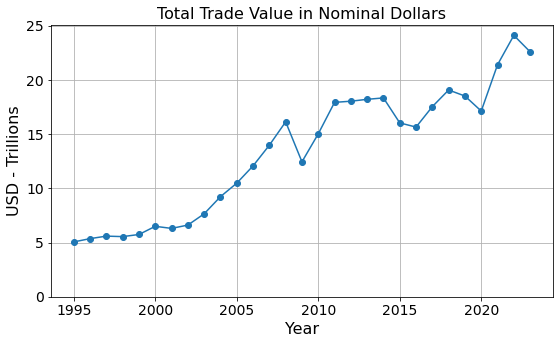

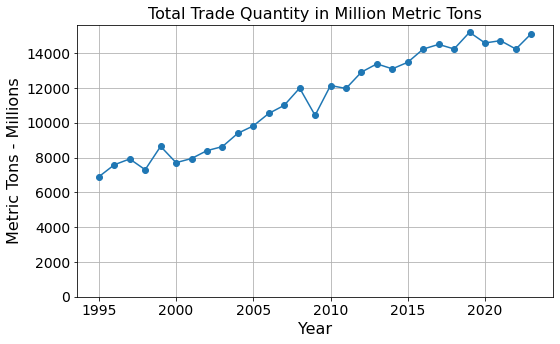

In [32]:
# Trade value and quantity of All countries and products by year
by_year = data_df.groupby('year').agg({"value": "sum", "quantity": "sum"})
by_year.reset_index(inplace=True)
by_year = standard_unit_and_name_conversions(by_year)
util.plot_lines(by_year, "year", "value_trln_USD", title="Total Trade Value in Nominal Dollars", 
                xtitle="Year", ytitle="USD - Trillions", ymin=0)
util.plot_lines(by_year, "year", "quantity_mln_metric_tons", title="Total Trade Quantity in Million Metric Tons", 
                xtitle="Year", ytitle="Metric Tons - Millions", ymin=0)

## By product chapter

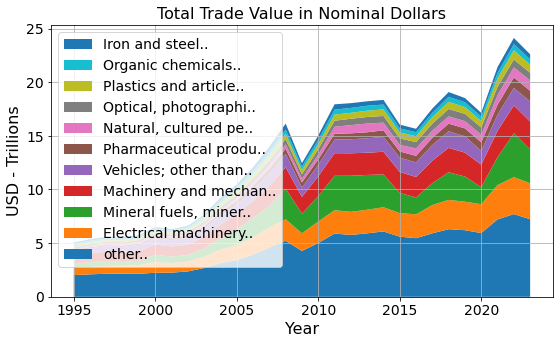

In [57]:
# Map the chapter code to the chapter name
df_ch = data_df.copy()
df_ch['product_chapter'] = df_ch['product_chapter'].map(epc22_df.set_index('hscode')['description'])
# Group by product_chapter
df_ch = df_ch.groupby(["year", "product_chapter"]).agg({"value": "sum", "quantity": "sum"})
df_ch.reset_index(inplace=True)
df_ch = standard_unit_and_name_conversions(df_ch)
# Pivot, make each chapter a column
df_ch = df_ch.pivot(index='year', columns='product_chapter', values='value_trln_USD')
df_ch.reset_index(inplace=True)
# Keep top 10
top_10 = list(df_ch.mean(axis=0).sort_values(ascending=False).iloc[1:11].index)
rest = list(set(df_ch.columns[1:]) - set(top_10))
new_df = pd.DataFrame(index=df_ch.index)
new_df["year"] = df_ch["year"]
# Sum the rest
new_df["other"] = df_ch[rest].sum(axis=1)
for col in top_10:
    new_df[col] = df_ch[col]



util.plot_lines(new_df, "year", new_df.columns[1:], title="Total Trade Value in Nominal Dollars", 
                xtitle="Year", ytitle="USD - Trillions", ymin=0, stacked=True)



del df_ch
del new_df

## By importer/exporter